In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In this notebook, I seek to predict go-arounds (i.e. aborted landings) for 176 large airports from 44 different countries in 2019. (dataset linked [here](https://zenodo.org/record/7148117)).

In [102]:
df_loaded = pd.read_csv("go_arounds_augmented.csv")

/var/folders/_j/vd_r650147l_5pl4bwls0xg00000gn/T/ipykernel_50292/1259920069.py:1: DtypeWarning: Columns (4,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loaded = pd.read_csv("go_arounds_augmented.csv")


In [185]:
df = df_loaded.copy()

In [186]:
df.columns

Index(['time', 'icao24', 'callsign', 'airport', 'runway', 'has_ga',
       'n_approaches', 'n_rwy_approached', 'registration', 'typecode',
       'icaoaircrafttype', 'wtc', 'glide_slope_angle', 'has_intersection',
       'rwy_length', 'airport_country', 'airport_region', 'operator_country',
       'operator_region', 'wind_speed_knts', 'wind_dir_deg', 'wind_gust_knts',
       'visibility_m', 'temperature_deg', 'press_sea_level_p', 'press_p',
       'weather_intensity', 'weather_precipitation', 'weather_desc',
       'weather_obscuration', 'weather_other'],
      dtype='object')

# Decoding Weather Info

This dataset uses METAR codes for weather ([link](http://moratech.com/aviation/metar-class/metar-pg9-ww.html)). I assign each precipitation/obscuration attribute with an integer between 1 (least intense) and 4 (most intense) which encodes the intensity of the phenomenon.

In [187]:
import ast

intensities_map = {'-' : 2, '': 3, '+': 4, 'VC': 1}
weather_types = ['MI', 'PR', 'BC', 'DR', 'BL', 'SH', 'TS', 'FZ', 'DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR', 'GS', 'UP', 'BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY', 'PO', 'SQ', 'FC', 'SS', 'DS']
multiple_precipitation_attributes = ['PLRA', 'RASN', 'SNRA', 'RAPL', 'RASNPL', 'SNPL', 'DZSN', 'PLSN', 'RAGR']

def encode_weather(df):
    for weather_type in weather_types:
        df[weather_type] = np.zeros(len(df))
    
    for weather_type in weather_types:
        df.loc[:, weather_type] = np.zeros(len(df))
    
    for index, row in df.iterrows():
        intensities = ast.literal_eval(row['weather_intensity'])
        for i in range(len(intensities)):
            for cat in ['weather_precipitation', 'weather_desc', 'weather_obscuration', 'weather_other']:
                attribute = ast.literal_eval(row[cat])[i]
                if attribute:
                    df.loc[index, attribute] = intensities_map[intensities[i]]
                    
    # Cleaning up codes with multiple precipitation attributes
    for weather_type in multiple_precipitation_attributes:
        col = df[weather_type].dropna()
        for i in range(0, len(weather_type), 2):
            attribute = weather_type[i : i + 2]
            for index in col.index:
                df.loc[index, attribute] = col[index]
                
    
    df.drop(multiple_precipitation_attributes, axis=1, inplace=True)

In [188]:
# Some records are missing, imputation infeasible :(
df = df.dropna()
encode_weather(df)
df

,time,icao24,callsign,airport,runway,has_ga,n_approaches,n_rwy_approached,registration,typecode,...,VA,DU,SA,HZ,PY,PO,SQ,FC,SS,DS
341,2019-01-06 18:50:59+00:00,ab7270,AAL750,KAUS,18L,False,1,1,N837AW,A319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,2019-01-06 18:53:45+00:00,abf8e0,SWA5180,KAUS,18L,False,1,1,N8701Q,B38M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,2019-01-06 18:54:58+00:00,a4c865,UAL422K,KAUS,18R,False,1,1,N407UA,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,2019-01-06 20:33:50+00:00,ab6eb9,AAL644,KAUS,18L,False,1,1,N836AW,A319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,2019-01-06 20:41:54+00:00,abdc91,ASH6150,KAUS,18R,False,1,1,N86311,E75L,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8962323,2019-07-15 20:42:46+00:00,a5d007,ASA788,KMSY,11,False,1,1,N474AS,B739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962333,2019-07-15 21:13:34+00:00,a81163,NKS6504,KMSY,11,False,1,1,N619NK,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962492,2019-07-16 20:31:17+00:00,a7f762,NKS1070,KMSY,11,False,1,1,N612NK,A320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8962493,2019-07-16 20:35:50+00:00,a726fb,ASA788,KMSY,11,False,1,1,N560AS,B738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering

One-hot encoding icao aircraft type ([link](https://skybrary.aero/articles/aircraft-description-icao-doc-8643)). Converting wake turbulence category to a numerical feature. Higher values mean more turbulence.

In [189]:
df = df.join(pd.get_dummies(df['icaoaircrafttype']))
df = df.join(pd.get_dummies(df['airport_region']))
df = df.join(pd.get_dummies(df['operator_region']), lsuffix='_airport_region', rsuffix='_operator_region')
df['wtc'] = df['wtc'].map({'H': 3, 'M': 2, 'L/M' : 1.5, 'L' : 1})

Crosswinds make landing difficult and thus may be a good predictor of go-arounds. Runway numberings are lettered according to the heading, rounded to the nearest 10 degrees. Thus, below, I calculate the angle between the wind and the runway to incorporate whether the pilot is landing into a crosswind.

In [190]:
import re

diffs = []

rwy_series = df['runway'].astype(str)
for idx, val in df['runway'].astype(str).items():
    runway_dir = int(re.sub(r'[A-Z]', "", val)) * 10
    diff = runway_dir - df.loc[idx, 'wind_dir_deg']
    
    if diff < -180:
        diff += 360
    elif diff < 0:
        diff += 180
    elif diff > 180:
        diff -= 180
        
    diffs.append(diff)
    
df['runway_wind_angle'] = diffs

## Undersampling to Rectify Class Imbalance

In [ ]:
df.columns

In [197]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


X = df.drop(['time', 'icao24', 'callsign', 'airport', 'runway', 'has_ga',
       'n_approaches', 'n_rwy_approached', 'registration', 'typecode',
       'icaoaircrafttype', 'airport_country', 'airport_region', 'operator_country',
       'operator_region', 'weather_intensity', 'weather_precipitation', 'weather_desc',
       'weather_obscuration', 'weather_other'], axis=1)
y = df['has_ga']

sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_oversampled, y_oversampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=21)

## Adaboost

In [198]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(n_estimators=1000, estimator=base_estimator)
clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=1000)

In [199]:
clf.score(X_test, y_test)

0.6813380281690141

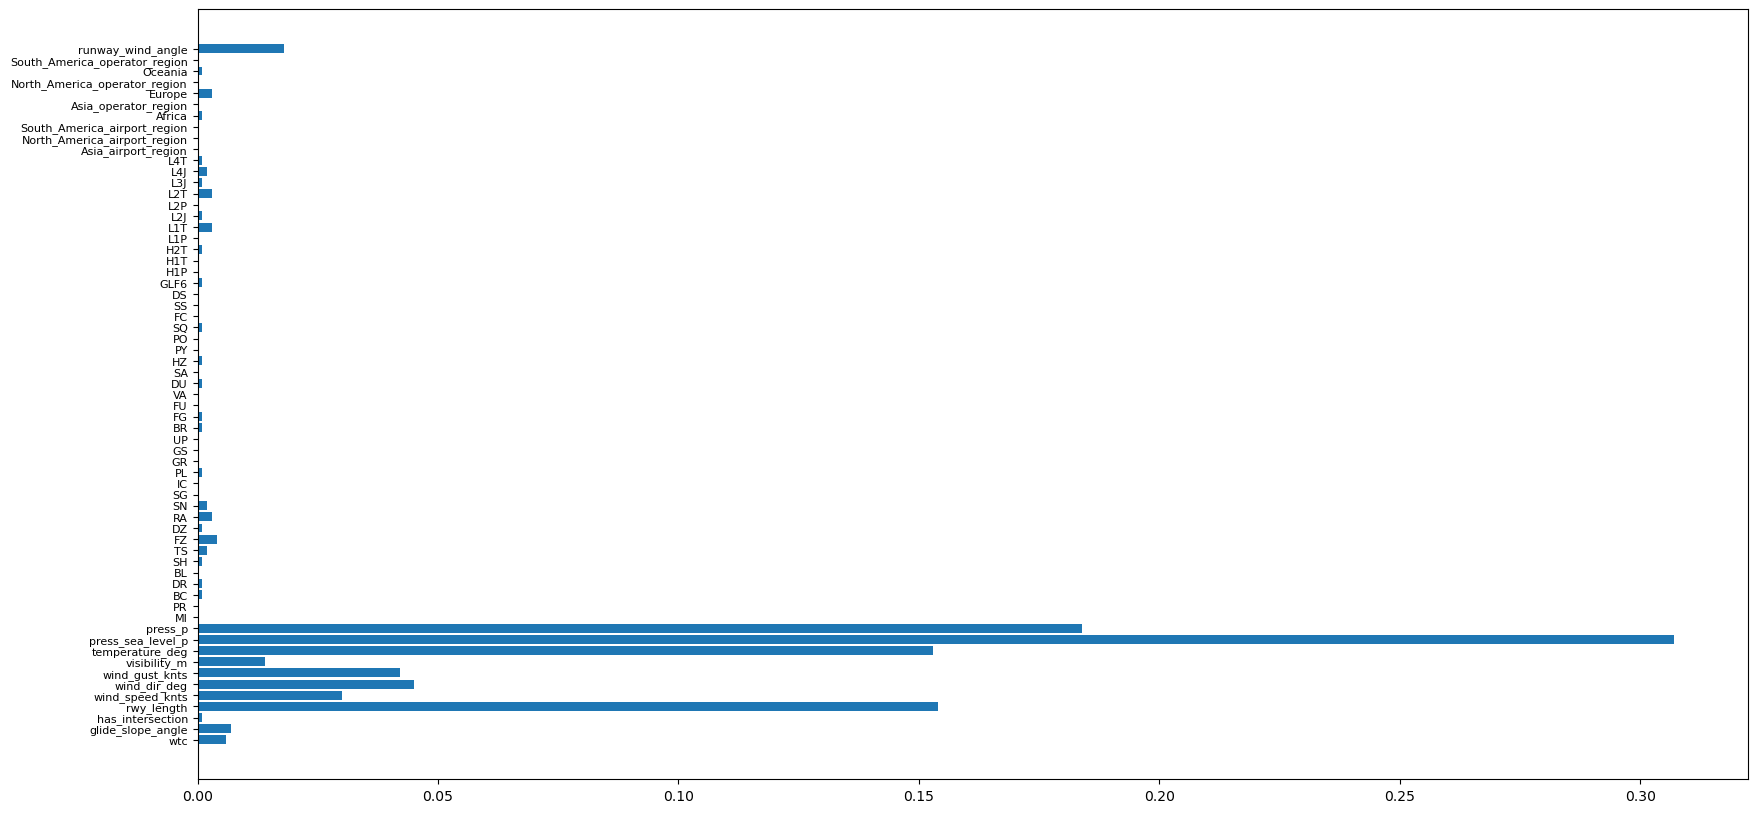

In [202]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_, label=X.columns)
ax.set_yticks(np.arange(len(clf.feature_importances_)), labels=X.columns, fontsize=8)
plt.rcParams["figure.figsize"] = (20,10);

In [203]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.5951556552119728

## Random Forest

In [293]:
X = df[['glide_slope_angle', 'rwy_length', 'wind_speed_knts', 'wind_gust_knts','visibility_m', 'temperature_deg','press_sea_level_p',
        'press_p', 'wtc','runway_wind_angle']]
y = df['has_ga']

sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_oversampled, y_oversampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=21)

In [294]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=21)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=21)

In [295]:
clf.score(X_test, y_test)

0.6892605633802817

In [296]:
clf.feature_importances_

array([0.01762285, 0.13648444, 0.10737066, 0.12087638, 0.05240336,
       0.14935719, 0.15355447, 0.13138268, 0.02411503, 0.10683295])

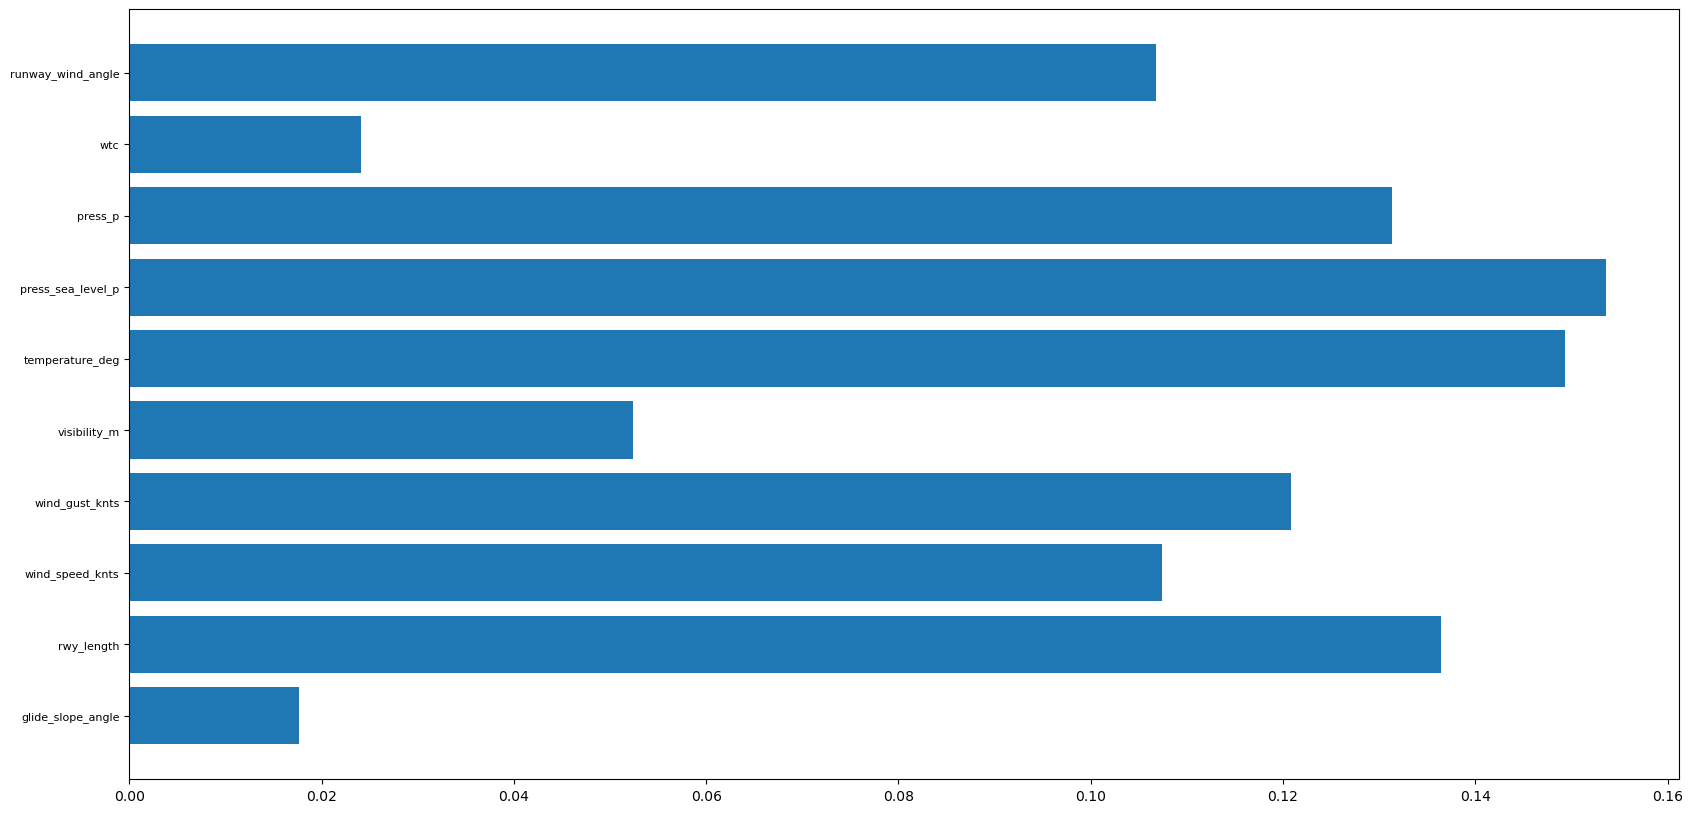

In [298]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_, label=X.columns)
ax.set_yticks(np.arange(len(clf.feature_importances_)), labels=X.columns, fontsize=8)
plt.rcParams["figure.figsize"] = (20,10);

## Hyperparameter Search for Random Forest

In [299]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf = RandomForestClassifier(max_features='sqrt', random_state=21)
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, cv = 3, verbose=2, n_iter=100, random_state=21, n_jobs = -1, scoring='roc_auc_ovr')

In [300]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=21),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=21, scoring='roc_auc_ovr', verbose=2)

In [301]:
clf.score(X_test, y_test)

0.6099668005075524

In [302]:
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.5941961724983053

[CV] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   6.4s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   3.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   7.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  11.5s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   8.0s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   9.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  13.3s
[CV] END bootstrap=False, max_depth=30, min_sampl

## XGBoost

In [303]:
X = df[['glide_slope_angle', 'rwy_length', 'wind_speed_knts', 'wind_gust_knts','visibility_m', 'temperature_deg','press_sea_level_p',
        'press_p', 'wtc','runway_wind_angle']]
y = df['has_ga']

sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=21)
X_oversampled, y_oversampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=21)

In [304]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=21)
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=21)

In [305]:
clf.score(X_test, y_test)

0.6980633802816901

In [306]:
clf.feature_importances_

array([0.04097756, 0.15106273, 0.0373702 , 0.2442885 , 0.18557461,
       0.08967568, 0.08499077, 0.0860281 , 0.01174949, 0.06828237])

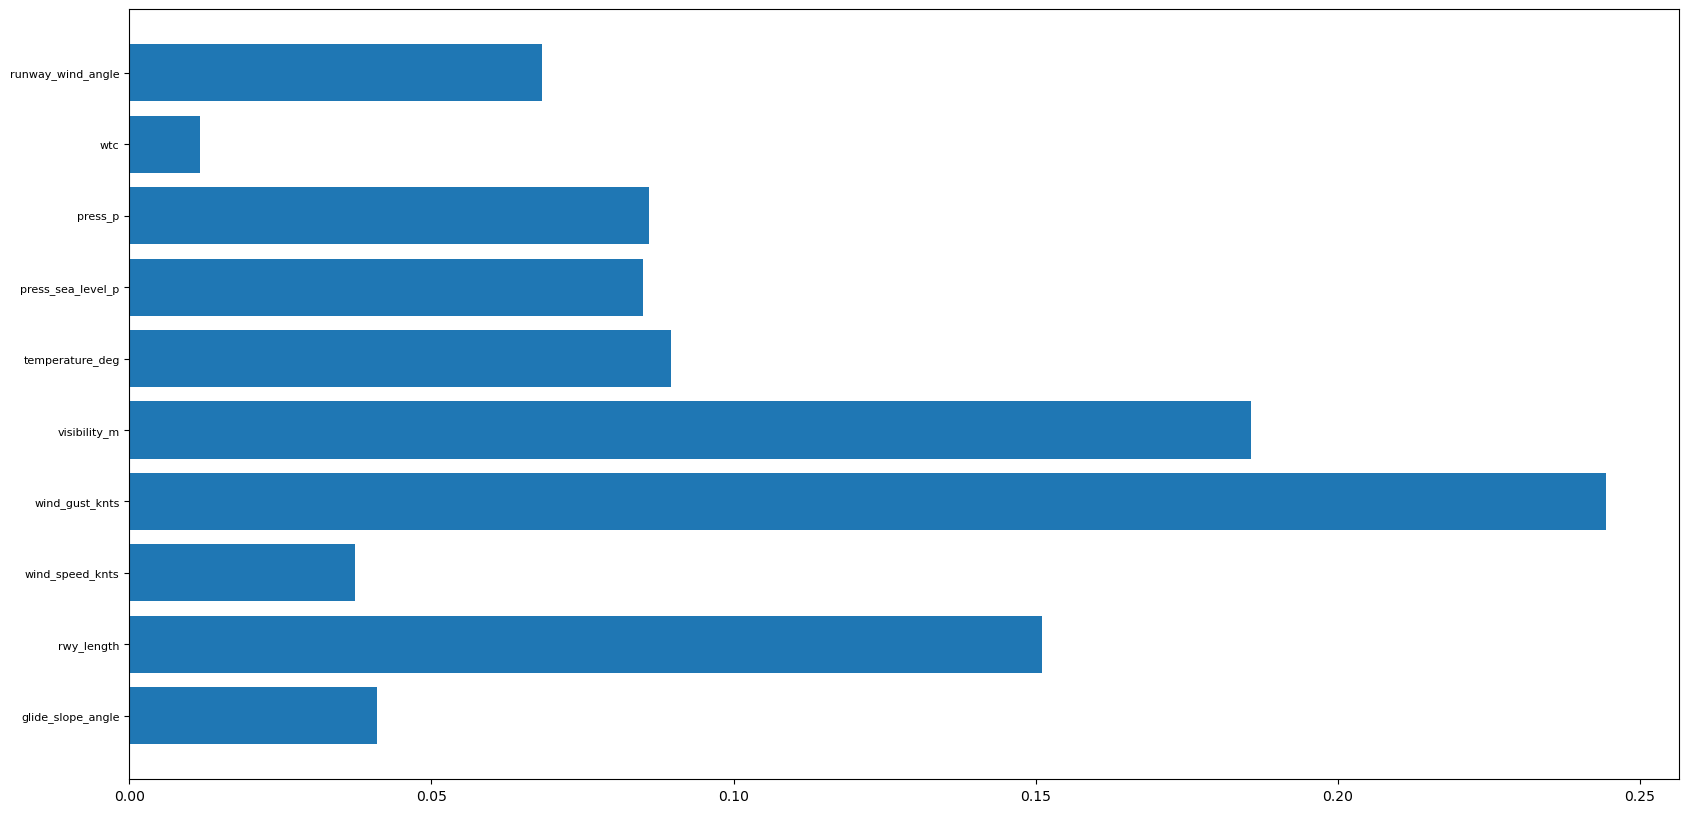

In [307]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_, label=X.columns)
ax.set_yticks(np.arange(len(clf.feature_importances_)), labels=X.columns, fontsize=8)
plt.rcParams["figure.figsize"] = (20,10);

## Hyperparameter Search for XGBoost

In [312]:
# Number of trees in ensemble
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Learning rate
lr = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# The fraction of samples to be used for fitting the individual base learners
subsample = list(np.arange(0.1, 1.01, 0.1))
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'subsample' : subsample,
               'learning_rate' : lr,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                }

clf = GradientBoostingClassifier(random_state=21)
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, cv = 3, verbose=2, n_iter=100, random_state=21, n_jobs = -1, scoring='roc_auc_ovr')

In [313]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=10, max_depth=70, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, subsample=0.4; total time=  27.4s
[CV] END learning_rate=1, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, subsample=0.2; total time=  14.6s
[CV] END learning_rate=0.01, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=400, subsample=0.7000000000000001; total time=  16.2s
[CV] END learning_rate=0.0001, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, subsample=0.9; total time= 3.4min


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=10, max_depth=70, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, subsample=0.4; total time=  27.2s
[CV] END learning_rate=1, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, subsample=0.2; total time=  14.5s
[CV] END learning_rate=0.01, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=400, subsample=0.7000000000000001; total time=  16.3s
[CV] END learning_rate=0.0001, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, subsample=0.9; total time= 3.4min
[CV] END learning_rate=1e-05, max_depth=100, min_samples_leaf=4, min_samples_split=10, n_estimators=1400, subsample=0.5; total time=  32.5s
[CV] END learning_rate=0.001, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=600, subsample=0.4; total time=  13.2s
[CV] END learning_rate=0.01, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=400, subsample=0.7000000000000001; total time=  16.6s
[CV] END 

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=21),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.0001, 0.001,
                                                          0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000],
                                        'subsample': [0.1, 0.2,
                                                      0.30000000000000004, 0.4,
                                                      0.5, 0.6,
                                                      0.7000000000000001, 0.8,
                                                      0.9, 1.0]},
                   random_state=21, scoring='roc_auc_ovr', verbose=2)

In [314]:
clf.score(X_test, y_test)

0.6216891762701848

In [315]:
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.5438963341502842